这就是一个preprocessing的file.主要功能就是把400张照片和对应的segmentation ground truth 读进来。然后把segmentation由rgb换成21-dim的one-hot array。再然后把照片和segmentation都拉成512,512.
最后把两个ndarray都输出，已有直接读ndarray就好了。
现在这些已经做完，并且upload到colab上了。不用再跑一遍这个文档。
之后靠读进来的ndarray去train.我的写在了fcn-mod里。

In [1]:
import os
import keras
import time
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from google.colab import drive
drive.mount('/content/drive/')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [6]:
dir_data = "/content/drive/My Drive/ipython notebooks/SemanticSegmentation/VOC2007/"
dir_source_file = dir_data + '/ImageSets/Segmentation/trainval.txt'
dir_source_file_2 = dir_data + '/ImageSets/Segmentation/test.txt'
dir_seg = dir_data + "/SegmentationClass/"
dir_img = dir_data + "/JPEGImages/"
source_files_arr = []
with open(dir_source_file, 'r') as dsf:
    for file_name in dsf:
      source_files_arr.append(file_name.rstrip('\n'))
with open(dir_source_file_2, 'r') as dfs2:
    for file_name in dfs2:
      source_files_arr.append(file_name.rstrip('\n'))
print(f'total num of image directories: {len(source_files_arr)}')

total num of image directories: 632


In [7]:
training_images = []
seg_images= []

#按顺序读前lim_read张
lim_read = 632 #应该是最大
cur_read = 0
image_reading_start_time = time.time()
for file_name in source_files_arr:
    img = cv2.cvtColor(cv2.imread(dir_img+file_name+'.jpg'), cv2.COLOR_BGR2RGB)
    seg = cv2.cvtColor(cv2.imread(dir_seg+file_name+'.png'), cv2.COLOR_BGR2RGB)
    training_images.append(img)
    seg_images.append(seg)
    cur_read += 1
    if cur_read >= lim_read:
        break
print(f'Total time to read images {time.time() - image_reading_start_time}s. Number of images read: {lim_read}.')

# #或者读一张自己挑的图
# lim_read = 1
# num_pic_to_read = 125 #<400
# file_name = source_files_arr[num_pic_to_read]
# img = cv2.cvtColor(cv2.imread(dir_img+file_name+'.jpg'), cv2.COLOR_BGR2RGB)
# seg = cv2.cvtColor(cv2.imread(dir_seg+file_name+'.png'), cv2.COLOR_BGR2RGB)
# training_images.append(img)
# seg_images.append(seg)

Total time to read images 586.8180572986603s. Number of images read: 632.


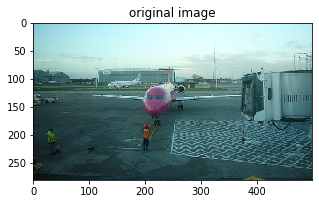

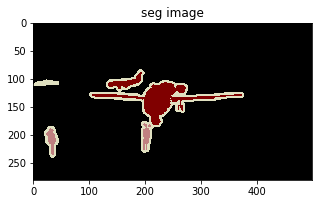

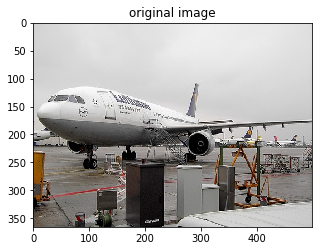

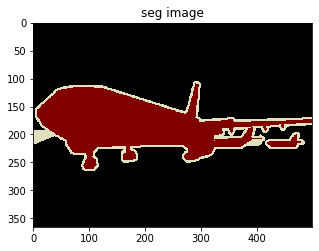

In [8]:
#检查一下，读进来了没有
i = 0
while i < 2:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(training_images[i])
    ax.set_title("original image")
    plt.show()
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(seg_images[i])
    ax.set_title("seg image")
    plt.show()
    i += 1

#这里可以检查一下每个pixel的值。这里会发现除了color map里的那些颜色以为，还有一个224 224 192。
#这个颜色不在color map里。因为它好像只是一个border.既不是背景，也不是一个需要被classify的object. 

# m1 = seg_images[0]
# row, col, channel = m1.shape
# for x in range(row):
#     for y in range(col):
#         if list(m1[x,y]) != [0,0,0]:
#             print(f'x {x}, y {y}, m[x,y] {m1[x, y]}')

#这里你们挑一个x,y不是0 0 0 或者224 224 192的pixel.
#然后到下面咱们的prediction里去查这个pixel

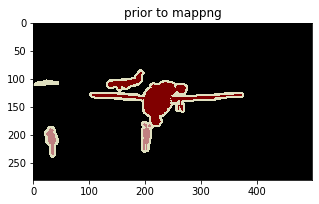

Total time to map 1 images from 3 channel rgb to 21 classes: 1.5661330223083496s.
(281, 500, 21)
Total time to map 632 images from 21 classes back to 3 channel rgb: 0.4853236675262451s.
(281, 500, 3)


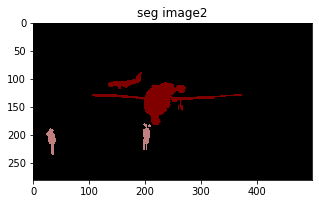

In [9]:
# mapping the 3rd dimension in segmented images
# Saved in the d2l package for later use
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
# Saved in the d2l package for later use
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']
# Border color to be ignored for now
border_color = [224, 224, 192]
back_ground_color = VOC_COLORMAP[0]
class_dic = {}
for i,j in enumerate(VOC_CLASSES):
    class_dic[i] = j

def map_rgb_to_one_of_21_classes(RGB_val):
    RGB_val = list(RGB_val)
    final_dim = np.zeros(21)
    if RGB_val == border_color or RGB_val == back_ground_color:
      return final_dim
    color_map_index = VOC_COLORMAP.index(list(RGB_val))
    final_dim[color_map_index] = 1
    return final_dim

def map_21_classes_back_to_rgb(size_21_array):
    rgb_color_index = np.argmax(size_21_array)
    rgb_color = VOC_COLORMAP[rgb_color_index]
    return rgb_color

def map_segmented_images_to_21_classes(seg_images):
    mapping_time_start = time.time()
    for i in range(len(seg_images)):
        row = seg_images[i].shape[0]
        col = seg_images[i].shape[1]
        seg = seg_images[i].copy()
        seg.resize(row, col, 21)
        for x in range(row):
          for y in range(col):
              seg[x,y] = map_rgb_to_one_of_21_classes(seg_images[i][x, y])
        seg_images[i] = seg      
    print(f'Total time to map {len(seg_images)} images from 3 channel rgb to 21 classes: {time.time() - mapping_time_start}s.')    
    return seg_images
  
def map_21_class_tensor_back_to_rgb(tens):
    mapping_back_start = time.time()
    for i in range(len(tens)):
        row = tens[i].shape[0]
        col = tens[i].shape[1]
        seg = tens[i].copy()
        seg.resize(row, col, 3)
        for x in range(row):
          for y in range(col):
              seg[x,y] = map_21_classes_back_to_rgb(tens[i][x, y])
        tens[i] = seg
    print(f'Total time to map {len(seg_images)} images from 21 classes back to 3 channel rgb: {time.time() - mapping_back_start}s.')
    return tens

#Testing the mapping function. Make sure they work in both directions
k = [seg_images[0]]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(k[0])
ax.set_title("prior to mappng")
plt.show()

#map forward
k = map_segmented_images_to_21_classes(k)
print(k[0].shape)
#map backward
k = map_21_class_tensor_back_to_rgb(k)
print(k[0].shape)

#shoudl get original image backwithout border
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(k[0])
ax.set_title("seg image2")
plt.show()

In [10]:
seg_images = map_segmented_images_to_21_classes(seg_images)

Total time to map 632 images from 3 channel rgb to 21 classes: 1964.696278810501s.


In [11]:
#resize images and segmented images
resized_size = 512
resize_time_start = time.time()
for i in range(len(training_images)):
    training_images[i] = cv2.resize(training_images[i], (resized_size, resized_size))
for i in range(len(seg_images)):
    seg_images[i] = cv2.resize(seg_images[i], (resized_size,resized_size))
print(f'resizing took {time.time() - resize_time_start}s')

resizing took 6.56969428062439s


In [12]:
#output the resized/mapped training and segmented_images in nparray binary file, so we won't ever have to map it again.
output_starting_time = time.time()
train_np = np.stack(training_images, axis=0)
seg_np = np.stack(seg_images, axis=0)
np.save(f'/content/drive/My Drive/ipython notebooks/SemanticSegmentation/2007_training_images_size{resized_size}.npy', train_np)
np.save(f'/content/drive/My Drive/ipython notebooks/SemanticSegmentation/2007_segmented_images_size{resized_size}.npy', seg_np)
print(f'Took {time.time()-output_starting_time}s to output {lim_read} images and segmented images to ndarrayfile')

Took 19.349266290664673s to output 632 images and segmented images to ndarrayfile
